In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

from IPython.display import display


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# -----------------------
# Load processed data
# -----------------------

df = pd.read_csv("data/sales_cleaned.csv") # sales

# -----------------------
# Features for clustering
# (NO churn label)
# -----------------------
numeric_features = [
    "annual_contract_value",
    "discount_pct",
    "initial_onboarding_score"
]

categorical_features = [
    "company_size_bucket",
    "product_tier",
    "sales_segment",
    "acquisition_channel" #TODO: industry
]

X_cluster = df[numeric_features + categorical_features]

# -----------------------
# Preprocessing
# -----------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [10]:
# ==========================================================
# Task 2 HIERARCHICAL CLUSTERING (VALIDATION)
# ==========================================================

from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# -----------------------
# Select numeric features only
# -----------------------
numeric_features = [
    "annual_contract_value",
    "discount_pct",
    "initial_onboarding_score"
]

X_hier = df[numeric_features]

# -----------------------
# Impute + scale
# -----------------------
X_hier = SimpleImputer(strategy="median").fit_transform(X_hier)
X_hier = StandardScaler().fit_transform(X_hier)

# -----------------------
# Hierarchical clustering
# -----------------------
Z = linkage(X_hier, method="ward")

# Cut dendrogram into 4 clusters (for comparison)
cut = 4
df["hier_cluster"] = fcluster(Z, t=cut, criterion="maxclust")

# -----------------------
# Churn concentration by hierarchical cluster
# -----------------------
hier_summary = (
    df
    .groupby("hier_cluster")
    .agg(
        customers=("customer_id", "count"),
        churn_count=("is_churned", "sum"),
        churn_rate=("is_churned", "mean"),
        avg_acv=("annual_contract_value", "mean"),
        avg_discount=("discount_pct", "mean"),
        avg_onboarding=("initial_onboarding_score", "mean")
    )
)

hier_summary["churn_share"] = (
    hier_summary["churn_count"] / hier_summary["churn_count"].sum()
)


hier_summary = hier_summary[
    [
        "customers",
        "churn_count",
        "churn_rate",
        "churn_share",
        "avg_acv",
        "avg_discount",
        "avg_onboarding"
    ]
].sort_values("churn_share", ascending=False)

# Re-label clusters as 0–3 based on ranking
hier_summary["ranked_cluster"] = range(1,len(hier_summary) + 1)

# Move ranked_cluster to index
hier_summary = hier_summary.set_index("ranked_cluster")

print("\n=== Hierarchical Clustering — Churn Concentration ===")
display(hier_summary)



=== Hierarchical Clustering — Churn Concentration ===


,customers,churn_count,churn_rate,churn_share,avg_acv,avg_discount,avg_onboarding
ranked_cluster,,,,,,,
1,1200,172,0.143333,0.472527,24513.294292,0.308875,5.693250
2,947,119,0.125660,0.326923,27008.081658,0.110781,5.664942
3,729,69,0.094650,0.189560,10554.806406,0.133676,7.963237
4,124,4,0.032258,0.010989,364083.102742,0.181129,6.449194



=== 80/20 Lost Revenue by Hierarchical Cluster ===
   hier_cluster  customers  churned  lost_revenue        avg_acv  loss_share  \
1             2       1200      172    2304843.93   24513.294292    0.441113   
0             1        124        4    1490347.12  364083.102742    0.285230   
3             4        947      119    1169070.70   27008.081658    0.223743   
2             3        729       69     260804.99   10554.806406    0.049914   

   cum_loss_share  
1        0.441113  
0        0.726343  
3        0.950086  
2        1.000000  


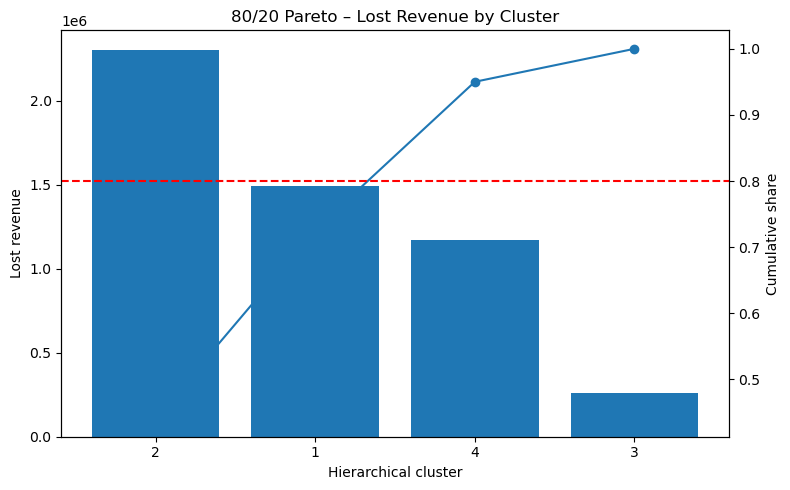

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Lost revenue definition
df["lost_revenue"] = df["annual_contract_value"] * df["is_churned"]

# Aggregate by hierarchical cluster
rev_8020 = (
    df.groupby("hier_cluster")
      .agg(
          customers=("customer_id", "count"),
          churned=("is_churned", "sum"),
          lost_revenue=("lost_revenue", "sum"),
          avg_acv=("annual_contract_value", "mean")
      )
      .reset_index()
)

# Sort by lost revenue (descending)
rev_8020 = rev_8020.sort_values("lost_revenue", ascending=False)

# Cumulative share
total_loss = rev_8020["lost_revenue"].sum()
rev_8020["loss_share"] = rev_8020["lost_revenue"] / total_loss
rev_8020["cum_loss_share"] = rev_8020["loss_share"].cumsum()

print("\n=== 80/20 Lost Revenue by Hierarchical Cluster ===")
print(rev_8020)

# Plot
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.bar(
    rev_8020["hier_cluster"].astype(str),
    rev_8020["lost_revenue"]
)
ax1.set_ylabel("Lost revenue")

ax2 = ax1.twinx()
ax2.plot(
    rev_8020["hier_cluster"].astype(str),
    rev_8020["cum_loss_share"],
    marker="o"
)
ax2.axhline(0.8, linestyle="--", color="red")
ax2.set_ylabel("Cumulative share")

ax1.set_xlabel("Hierarchical cluster")
ax1.set_title("80/20 Pareto – Lost Revenue by Cluster")

plt.tight_layout()
plt.show()

#### Churn Spike BEFORE & AFTER

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Ensure lost_revenue is defined (handling the split by period)
df["lost_revenue"] = df["annual_contract_value"] * df["is_churned"]

# 2. Aggregate by BOTH hierarchical cluster and Q3_Status
# This identifies which [Cluster + Period] combo is hurting the bottom line most
rev_8020_q3 = (
    df.groupby(["hier_cluster"])
      .agg(
          customers=("customer_id", "count"),
          churned=("is_churned", "sum"),
          lost_revenue=("lost_revenue", "sum"),
          avg_acv=("annual_contract_value", "mean")
      )
      .reset_index()
)

# 3. Sort by lost revenue (descending) to find the primary churn drivers
rev_8020_q3 = rev_8020_q3.sort_values("lost_revenue", ascending=False)

# 4. Calculate Cumulative share across all segments
total_loss = rev_8020_q3["lost_revenue"].sum()
rev_8020_q3["loss_share"] = rev_8020_q3["lost_revenue"] / total_loss
rev_8020_q3["cum_loss_share"] = rev_8020_q3["loss_share"].cumsum()

# Create a label for the plot (Cluster + Period)
rev_8020_q3["cluster_period"] = (
    rev_8020_q3["hier_cluster"].astype(str) + " | " + rev_8020_q3["Q3_Status"]
)

print("\n=== 80/20 Lost Revenue by Cluster and Q3 Status ===")
print(rev_8020_q3[['cluster_period', 'customers', 'churned', 'lost_revenue', 'cum_loss_share']].head(10))

# 5. Plot the Pareto Chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for absolute lost revenue
bars = ax1.bar(
    rev_8020_q3["cluster_period"],
    rev_8020_q3["lost_revenue"],
    color=['#e74c3c' if 'During' in s else '#3498db' for s in rev_8020_q3["Q3_Status"]]
)
ax1.set_ylabel("Lost Revenue ($)")
ax1.set_xlabel("Cluster | Period")
ax1.set_title("Pareto Analysis: Where is the Q3 Churn Spike coming from?")

# Line chart for cumulative share
ax2 = ax1.twinx()
ax2.plot(
    rev_8020_q3["cluster_period"],
    rev_8020_q3["cum_loss_share"],
    marker="o", color="black", linewidth=2
)
ax2.axhline(0.8, linestyle="--", color="red", alpha=0.6, label="80% Threshold")
ax2.set_ylabel("Cumulative Share of Total Loss")
ax2.set_ylim(0, 1.1)

# Formatting
ax1.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

KeyError: 'Q3_Status'

## Aggregate tickets information


=== Within-cluster: churned vs retained ticket behavior ===
   hier_cluster  is_churned  customers  lost_revenue  avg_tickets  \
0             1           0        358          0.00     0.963687   
1             1           1         11    3789467.07     1.000000   
2             2           0       2451          0.00     0.936353   
3             2           1        310    5771796.62     0.877419   
4             3           0       1531          0.00     0.919007   
5             3           1        115     440532.01     0.852174   
6             4           0       1946          0.00     0.916238   
7             4           1        251    3579149.60     0.868526   

   avg_sentiment  avg_first_response_hours  avg_resolution_hours  \
0      -0.026704                  3.127905             10.814846   
1      -0.140000                  5.522727             15.862727   
2      -0.046844                  3.496907             11.017152   
3      -0.046177                  4.027694   

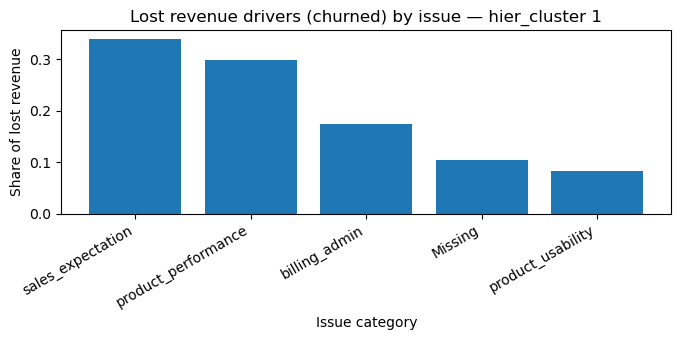

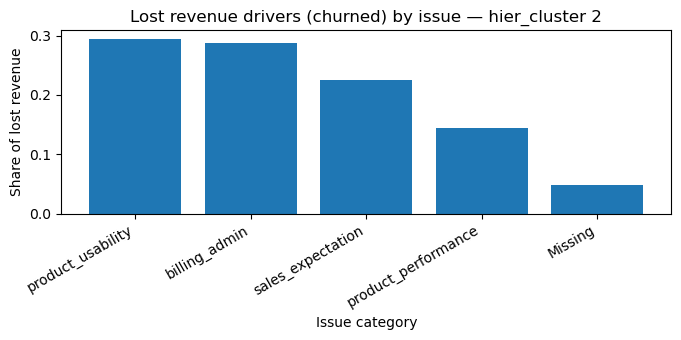

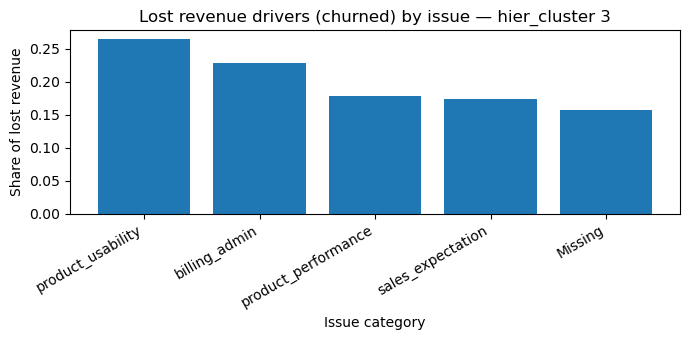

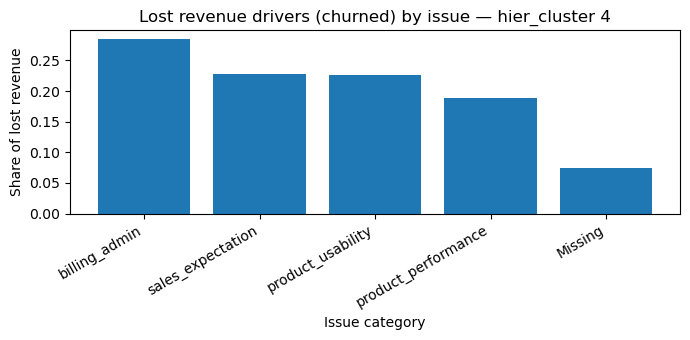

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tickets = pd.read_csv("data/tickets_aggregated.csv")

# drop junk index col if present
tickets = tickets.drop(columns=["Unnamed: 0"], errors="ignore")

# key consistency
tickets["customer_id"] = tickets["customer_id"].astype(str)
df["customer_id"] = df["customer_id"].astype(str)

# merge
df_tickets = df.merge(tickets, on="customer_id", how="left")

# fill missing ticket info for customers w/ no tickets
fill_cols = [
    "avg_sentiment",
    "avg_first_response_hours",
    "avg_resolution_hours",
    "avg_resolved",
    "ticket_count",
]
for c in fill_cols:
    if c in df_tickets.columns:
        df_tickets[c] = pd.to_numeric(df_tickets[c], errors="coerce").fillna(0)

# fill categorical ticket fields
for c in ["Q3_Status", "channel", "priority", "issue_category", "ticket_text"]:
    if c in df_tickets.columns:
        df_tickets[c] = df_tickets[c].fillna("Missing").astype(str)

# 1) Pick priority clusters
priority_clusters = [2, 1, 4, 3]
df_priority = df_tickets[df_tickets["hier_cluster"].isin(priority_clusters)].copy()

# 2) Cluster-level ticket + churn summary (numbers)
ticket_cluster_summary = (
    df_priority
    .groupby(["hier_cluster", "Q3_Status"])
    .agg(
        customers=("customer_id", "count"),
        churned=("is_churned", "sum"),
        churn_rate=("is_churned", "mean"),
        lost_revenue=("lost_revenue", "sum"),
        avg_acv=("annual_contract_value", "mean"),
        avg_tickets=("ticket_count", "mean"),
        avg_sentiment=("avg_sentiment", "mean"),
        avg_first_response_hours=("avg_first_response_hours", "mean"),
        avg_resolution_hours=("avg_resolution_hours", "mean"),
        resolved_rate=("avg_resolved", "mean"),
    )
    .reset_index()
    .sort_values("lost_revenue", ascending=False)
)

# 3) Within each cluster: churned vs retained differences
ticket_churn_compare = (
    df_priority
    .groupby(["hier_cluster", "is_churned"])
    .agg(
        customers=("customer_id", "count"),
        lost_revenue=("lost_revenue", "sum"),
        avg_tickets=("ticket_count", "mean"),
        avg_sentiment=("avg_sentiment", "mean"),
        avg_first_response_hours=("avg_first_response_hours", "mean"),
        avg_resolution_hours=("avg_resolution_hours", "mean"),
        resolved_rate=("avg_resolved", "mean"),
    )
    .reset_index()
    .sort_values(["hier_cluster", "is_churned"])
)

print("\n=== Within-cluster: churned vs retained ticket behavior ===")
print(ticket_churn_compare)


# 4) Top issue_category among churned customers per cluster
churned_only = df_priority[df_priority["is_churned"] == 1].copy()

churn_issue = (
    churned_only
    .groupby(["hier_cluster", "issue_category"])["lost_revenue"]
    .sum()
    .reset_index(name="lost_revenue")
)

churn_issue["cluster_lost_total"] = churn_issue.groupby("hier_cluster")["lost_revenue"].transform("sum")
churn_issue["lost_share"] = np.where(
    churn_issue["cluster_lost_total"] > 0,
    churn_issue["lost_revenue"] / churn_issue["cluster_lost_total"],
    0.0
)

print("\n=== Among churned in each cluster: lost revenue by issue_category ===")
print(churn_issue.sort_values(["hier_cluster", "lost_share"], ascending=[True, False]))


topk = 6
for hc in sorted(churned_only["hier_cluster"].unique()):
    sub = churn_issue[churn_issue["hier_cluster"] == hc].sort_values("lost_share", ascending=False).head(topk)
    fig, ax = plt.subplots(figsize=(7,3.5))
    ax.bar(sub["issue_category"].astype(str), sub["lost_share"])
    ax.set_title(f"Lost revenue drivers (churned) by issue — hier_cluster {hc}")
    ax.set_ylabel("Share of lost revenue")
    ax.set_xlabel("Issue category")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


=== Within-cluster/period: churned vs retained ticket behavior ===
    hier_cluster        Q3_Status  is_churned  customers  avg_tickets  \
0              1        Before Q3           0         86     1.000000   
1              1  During/After Q3           0        258     1.003876   
2              1  During/After Q3           1         10     1.100000   
3              1          Missing           0         14     0.000000   
4              1          Missing           1          1     0.000000   
5              2        Before Q3           0        572     1.006993   
6              2        Before Q3           1         63     1.000000   
7              2  During/After Q3           0       1705     1.008211   
8              2  During/After Q3           1        208     1.004808   
9              2          Missing           0        174     0.000000   
10             2          Missing           1         39     0.000000   
11             3        Before Q3           0        373

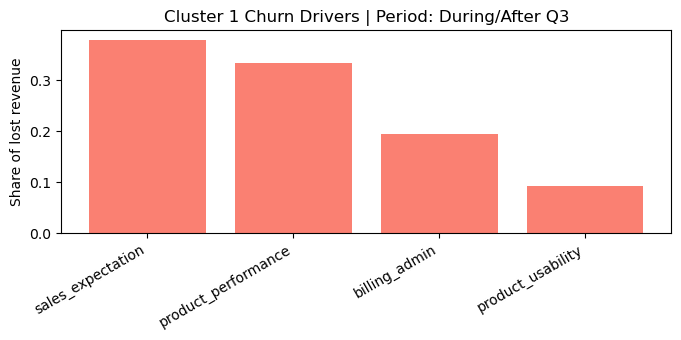

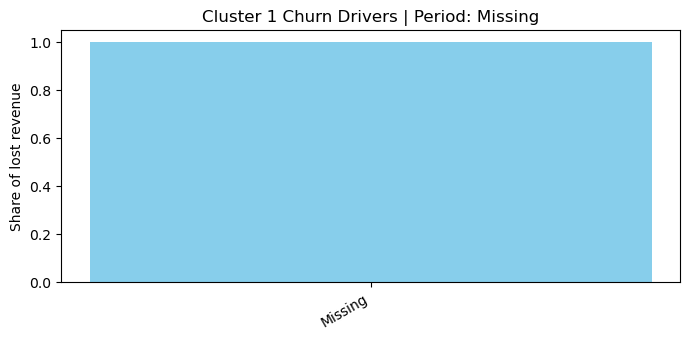

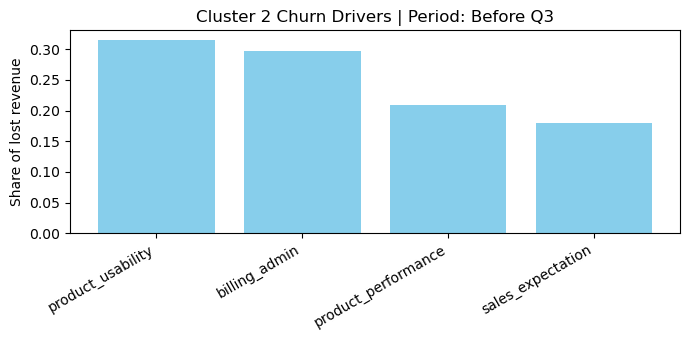

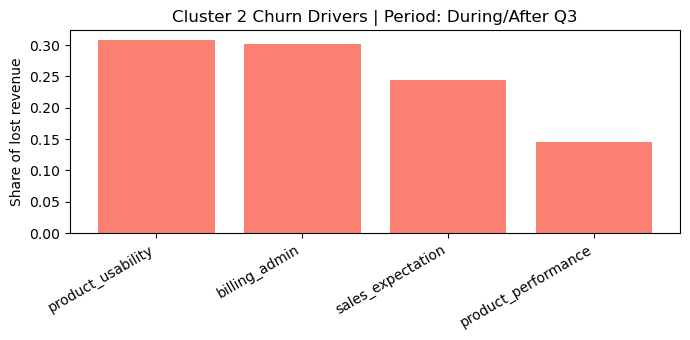

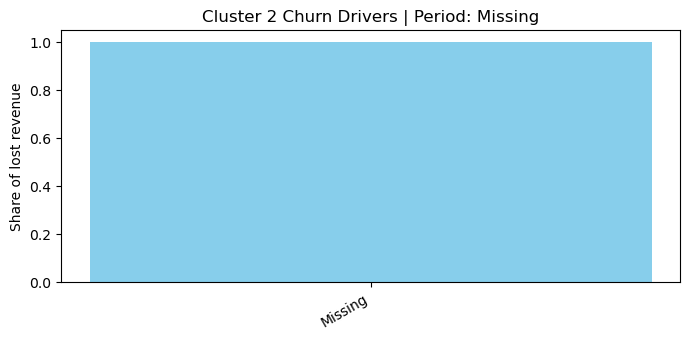

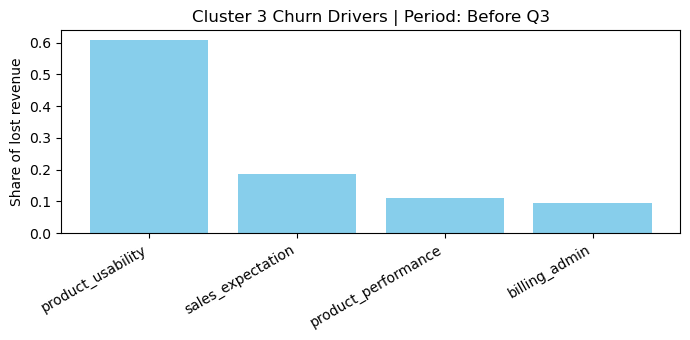

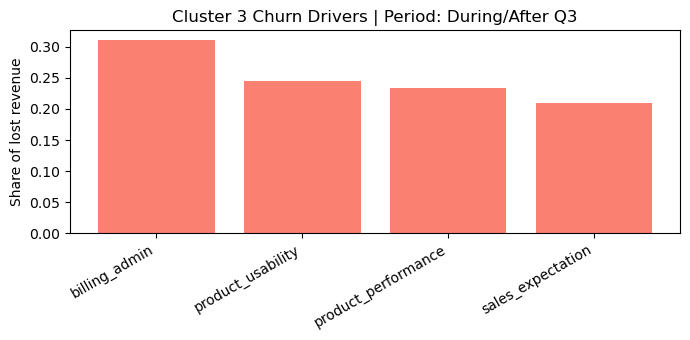

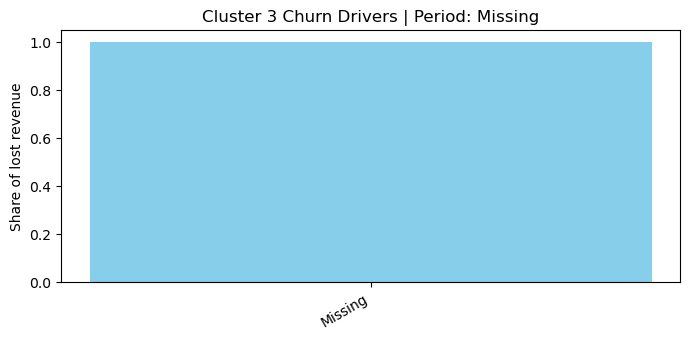

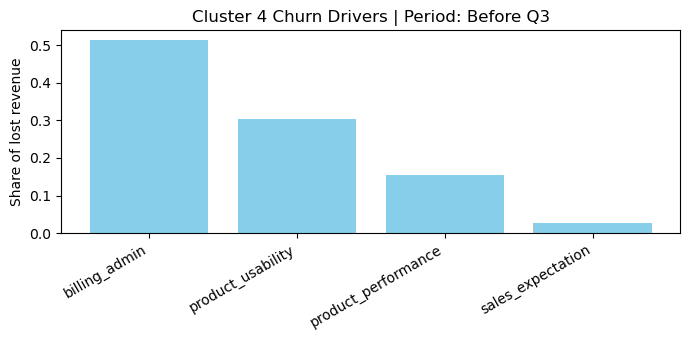

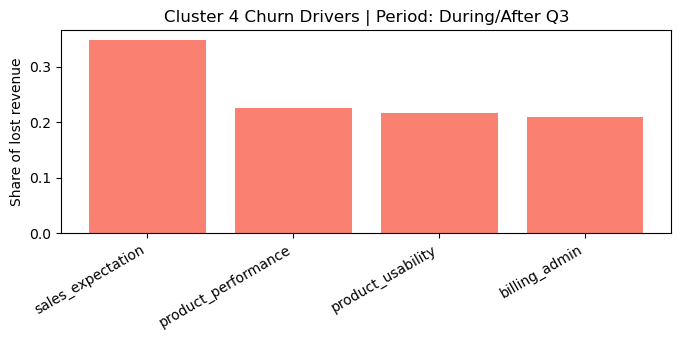

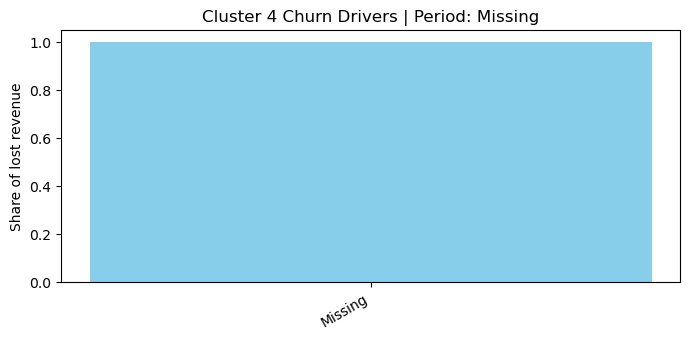

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ... [Keep your loading and merge code as is] ...

# 1) Pick priority clusters
priority_clusters = [2, 1, 4, 3]
df_priority = df_tickets[df_tickets["hier_cluster"].isin(priority_clusters)].copy()

# 2) Cluster-level ticket + churn summary (Already includes Q3_Status from your prev step)
ticket_cluster_summary = (
    df_priority
    .groupby(["hier_cluster", "Q3_Status"])
    .agg(
        customers=("customer_id", "count"),
        churned=("is_churned", "sum"),
        churn_rate=("is_churned", "mean"),
        lost_revenue=("lost_revenue", "sum"),
        avg_tickets=("ticket_count", "mean"),
        avg_sentiment=("avg_sentiment", "mean"),
        avg_resolution_hours=("avg_resolution_hours", "mean"),
    )
    .reset_index()
    .sort_values(["hier_cluster", "Q3_Status"])
)

# 3) ADDED Q3_STATUS: Within each cluster & time period, churned vs retained behavior
# This helps see if the "vibe" of churners changed during the Q3 spike
ticket_churn_compare = (
    df_priority
    .groupby(["hier_cluster", "Q3_Status", "is_churned"])
    .agg(
        customers=("customer_id", "count"),
        avg_tickets=("ticket_count", "mean"),
        avg_sentiment=("avg_sentiment", "mean"),
        avg_resolution_hours=("avg_resolution_hours", "mean"),
    )
    .reset_index()
    .sort_values(["hier_cluster", "Q3_Status", "is_churned"])
)

print("\n=== Within-cluster/period: churned vs retained ticket behavior ===")
print(ticket_churn_compare)

# 4) ADDED Q3_STATUS: Top issue_category among churned per cluster AND period
# This identifies if the *reasons* for churn shifted in Q3
churned_only = df_priority[df_priority["is_churned"] == 1].copy()

churn_issue = (
    churned_only
    .groupby(["hier_cluster", "Q3_Status", "issue_category"])["lost_revenue"]
    .sum()
    .reset_index(name="lost_revenue")
)

# Normalize lost_share relative to that specific cluster AND that specific time period
churn_issue["group_lost_total"] = churn_issue.groupby(["hier_cluster", "Q3_Status"])["lost_revenue"].transform("sum")
churn_issue["lost_share"] = np.where(
    churn_issue["group_lost_total"] > 0,
    churn_issue["lost_revenue"] / churn_issue["group_lost_total"],
    0.0
)

# 5) PLOTTING: Loop through Cluster and Period
topk = 6
# Sort to ensure "Before Q3" appears next to "During/After Q3" for easy visual comparison
periods = sorted(churned_only["Q3_Status"].unique())

for hc in sorted(churned_only["hier_cluster"].unique()):
    for status in periods:
        sub = (churn_issue[(churn_issue["hier_cluster"] == hc) & (churn_issue["Q3_Status"] == status)]
               .sort_values("lost_share", ascending=False).head(topk))
        
        if sub.empty: continue
        
        fig, ax = plt.subplots(figsize=(7, 3.5))
        # Use different colors to visually distinguish the Q3 spike
        color = 'salmon' if 'During' in status else 'skyblue'
        
        ax.bar(sub["issue_category"].astype(str), sub["lost_share"], color=color)
        ax.set_title(f"Cluster {hc} Churn Drivers | Period: {status}")
        ax.set_ylabel("Share of lost revenue")
        plt.xticks(rotation=30, ha="right")
        plt.tight_layout()
        plt.show()


=== Within-cluster/period: churned vs retained ticket behavior ===
    hier_cluster        Q3_Status  is_churned  customers  avg_tickets  \
0              1        Before Q3           0         86     1.000000   
1              1  During/After Q3           0        258     1.003876   
2              1  During/After Q3           1         10     1.100000   
3              1          Missing           0         14     0.000000   
4              1          Missing           1          1     0.000000   
5              2        Before Q3           0        572     1.006993   
6              2        Before Q3           1         63     1.000000   
7              2  During/After Q3           0       1705     1.008211   
8              2  During/After Q3           1        208     1.004808   
9              2          Missing           0        174     0.000000   
10             2          Missing           1         39     0.000000   
11             3        Before Q3           0        373

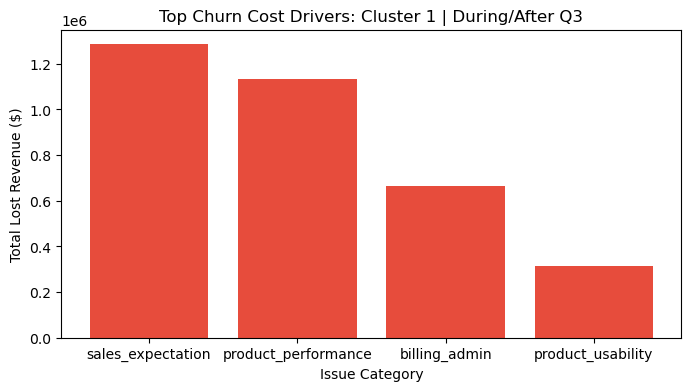

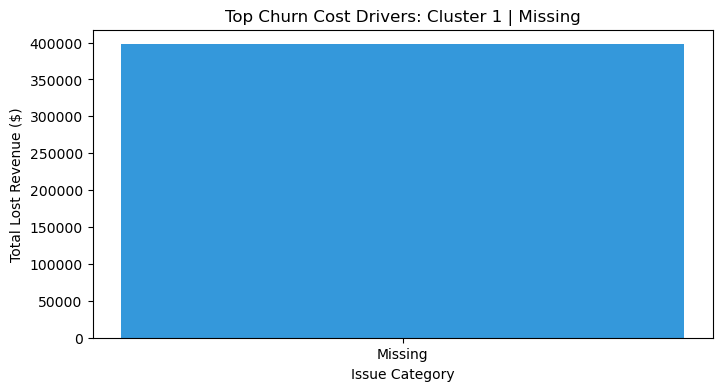

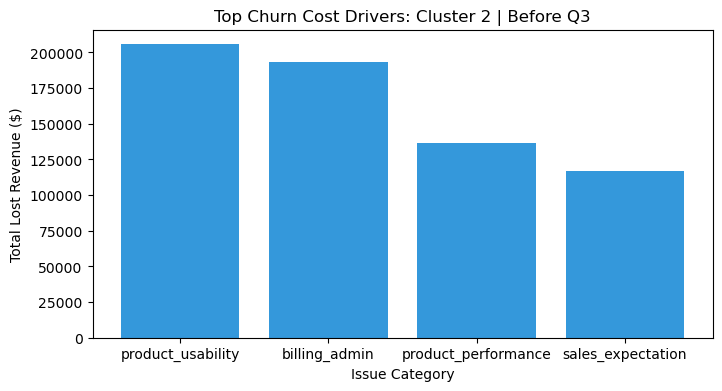

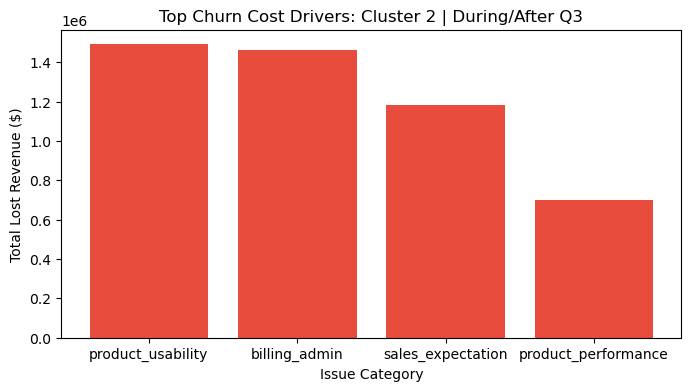

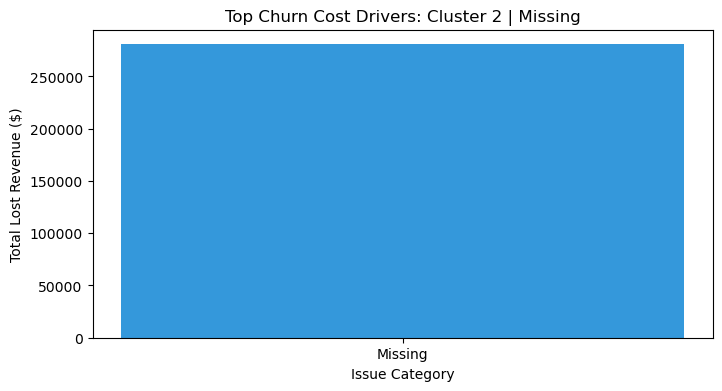

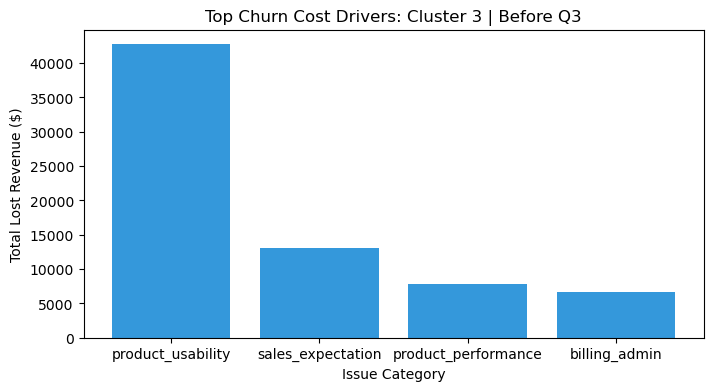

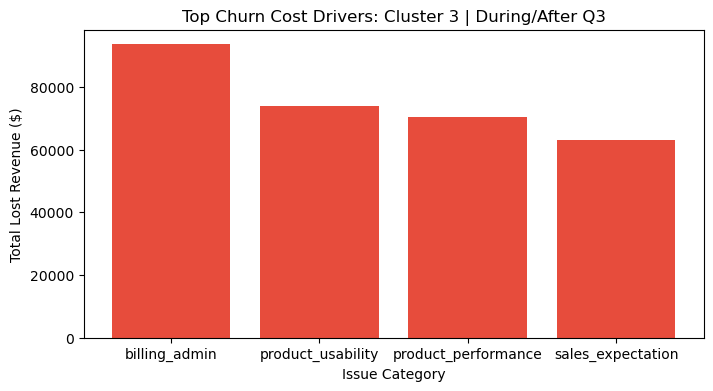

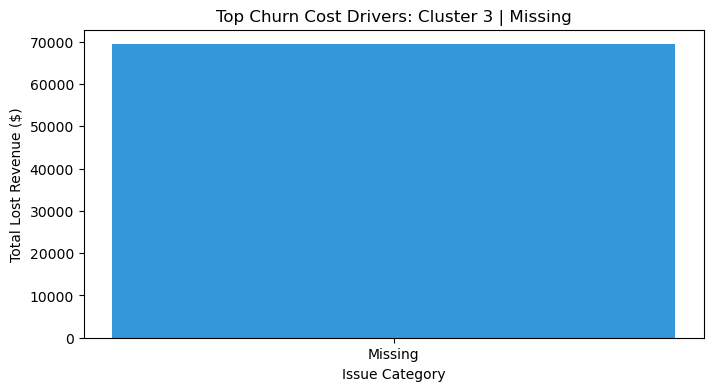

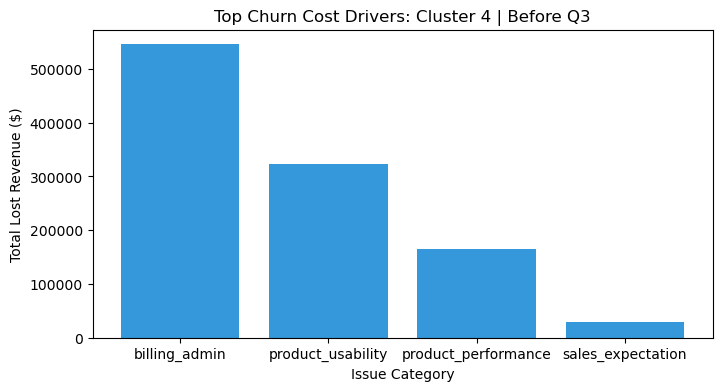

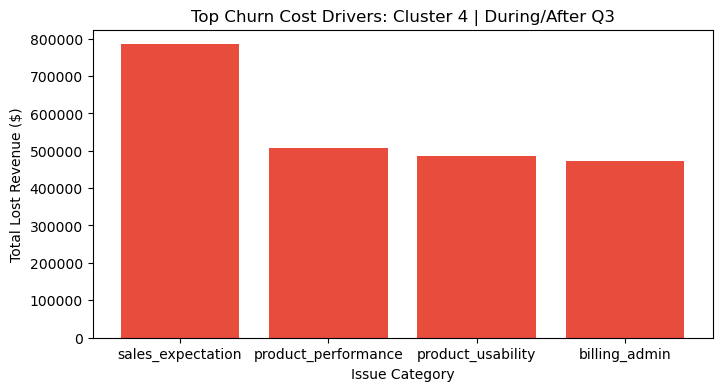

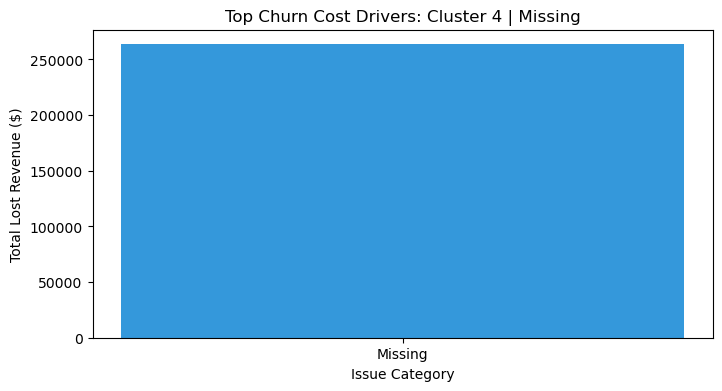

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ... [Keep your loading and merge code as is] ...

# 1) Pick priority clusters
priority_clusters = [2, 1, 4, 3]
df_priority = df_tickets[df_tickets["hier_cluster"].isin(priority_clusters)].copy()

# 2) Cluster-level ticket + churn summary
ticket_cluster_summary = (
    df_priority
    .groupby(["hier_cluster", "Q3_Status"])
    .agg(
        customers=("customer_id", "count"),
        churned=("is_churned", "sum"),
        churn_rate=("is_churned", "mean"),
        lost_revenue=("lost_revenue", "sum"),
        avg_tickets=("ticket_count", "mean"),
        avg_sentiment=("avg_sentiment", "mean"),
        avg_resolution_hours=("avg_resolution_hours", "mean"),
    )
    .reset_index()
    .sort_values(["hier_cluster", "Q3_Status"])
)

# 3) Within each cluster & time period, churned vs retained behavior
ticket_churn_compare = (
    df_priority
    .groupby(["hier_cluster", "Q3_Status", "is_churned"])
    .agg(
        customers=("customer_id", "count"),
        avg_tickets=("ticket_count", "mean"),
        avg_sentiment=("avg_sentiment", "mean"),
        avg_resolution_hours=("avg_resolution_hours", "mean"),
    )
    .reset_index()
    .sort_values(["hier_cluster", "Q3_Status", "is_churned"])
)

print("\n=== Within-cluster/period: churned vs retained ticket behavior ===")
print(ticket_churn_compare)

# 4) Top issue_category among churned customers per cluster AND period
churned_only = df_priority[df_priority["is_churned"] == 1].copy()

churn_issue = (
    churned_only
    .groupby(["hier_cluster", "Q3_Status", "issue_category"])["lost_revenue"]
    .sum()
    .reset_index(name="lost_revenue")
)

# 5) PLOTTING: Loop through Cluster and Period based on TOTAL LOST REVENUE
topk = 6
periods = sorted(churned_only["Q3_Status"].unique())

for hc in sorted(churned_only["hier_cluster"].unique()):
    for status in periods:
        # Filter for the specific Cluster + Period
        sub = churn_issue[(churn_issue["hier_cluster"] == hc) & (churn_issue["Q3_Status"] == status)]
        
        # Sort by TOTAL LOST REVENUE (not share) to find the biggest dollar drivers
        sub = sub.sort_values("lost_revenue", ascending=False).head(topk)
        
        if sub.empty: continue
        
        fig, ax = plt.subplots(figsize=(8, 4))
        
        # Use different colors to visually distinguish the Q3 spike
        color = '#E74C3C' if 'During' in status else '#3498DB'
        
        # Plot absolute Lost Revenue on the Y-axis
        ax.bar(sub["issue_category"].astype(str), sub["lost_revenue"], color=color)
        
        # Formatting for readability
        ax.set_title(f"Top Churn Cost Drivers: Cluster {hc} | {status}")
        ax.set_ylabel("Total Lost Revenue ($)")
        ax.set_xlabel("Issue Category")
        
        # Add dollar labels on top of bars
        for i, v in enumerate(sub["lost_revenue"]):
            ax.text

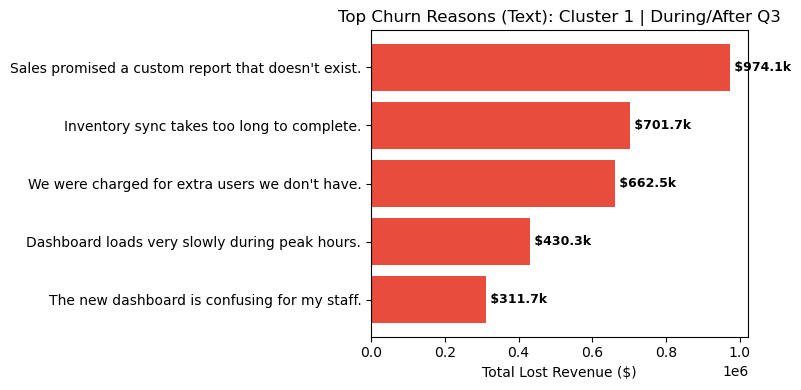

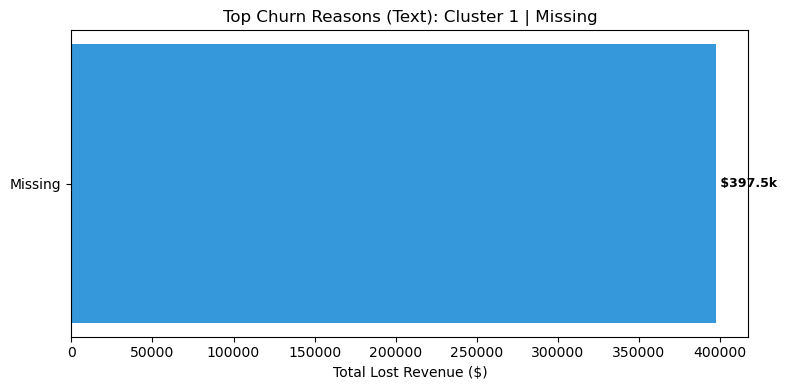

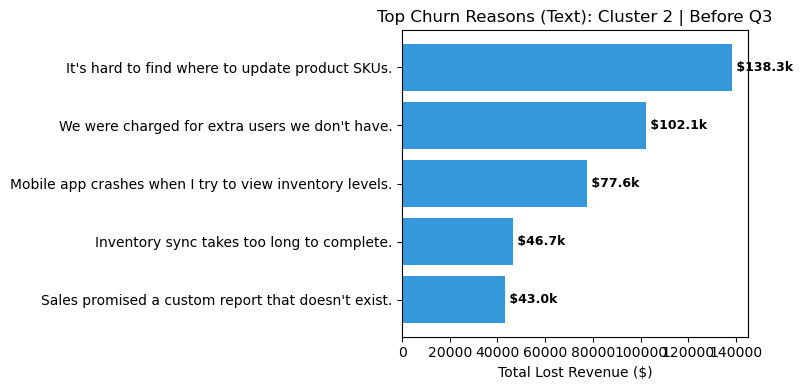

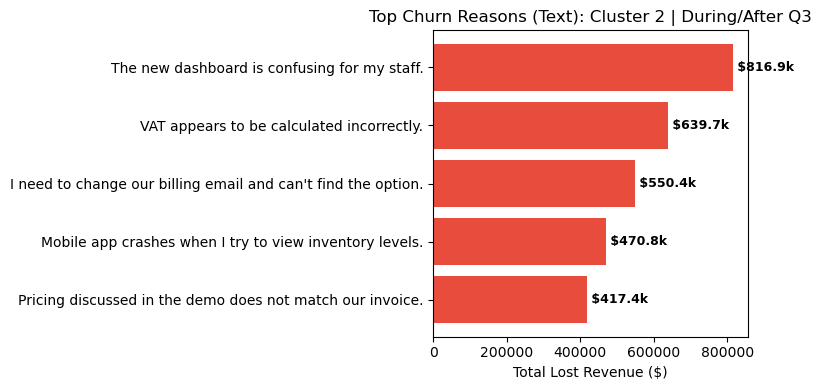

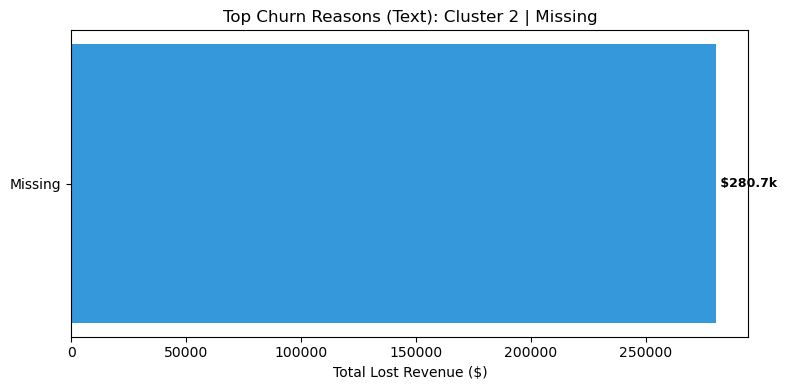

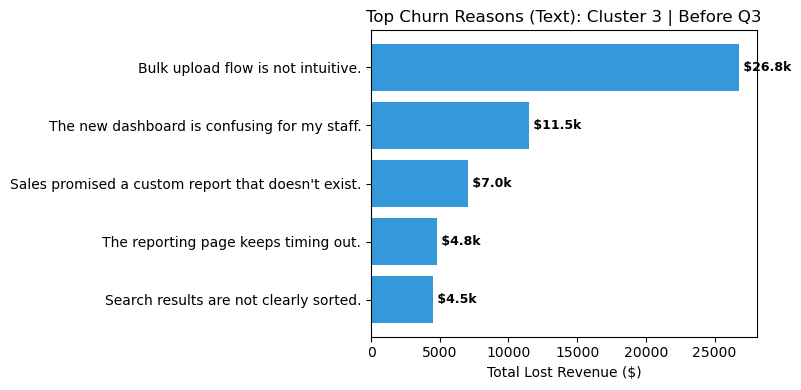

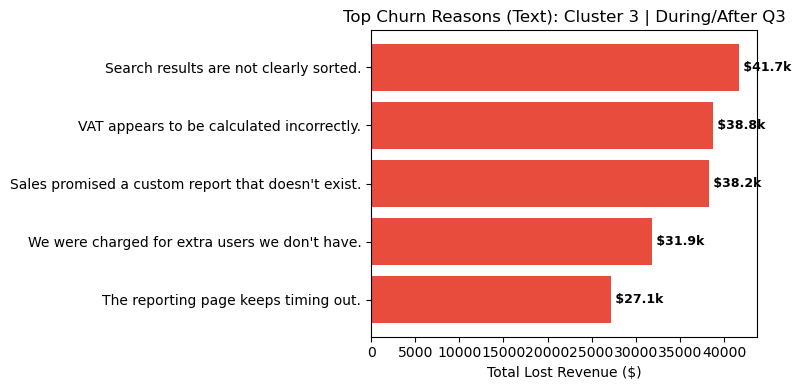

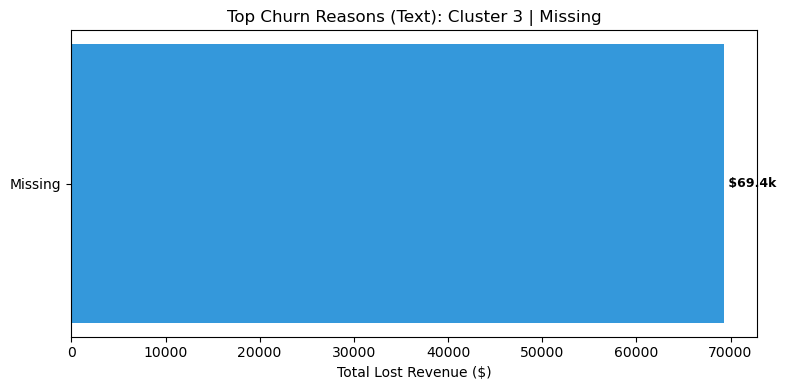

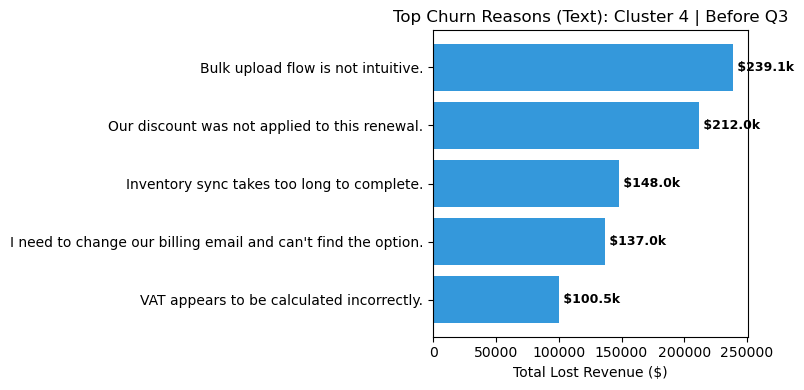

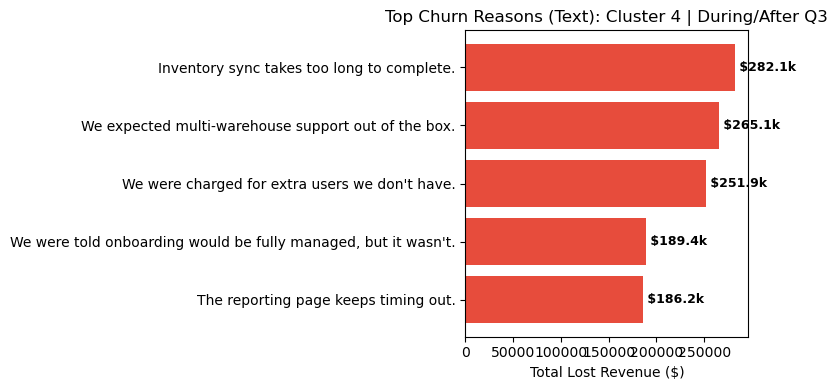

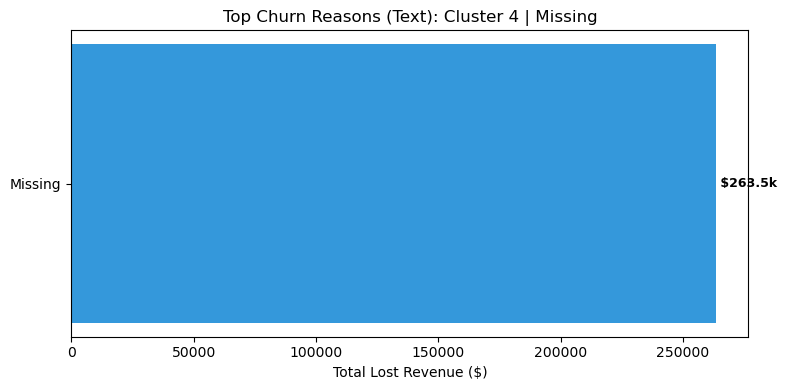

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ... [Keep your loading and merge code as is] ...

# 1) Pick priority clusters
priority_clusters = [2, 1, 4, 3]
df_priority = df_tickets[df_tickets["hier_cluster"].isin(priority_clusters)].copy()

# 2) Filter for CHURNED customers only (since we want to explain the loss)
churned_only = df_priority[df_priority["is_churned"] == 1].copy()

# 3) Group by Cluster, Period, AND Ticket Text
# This effectively pivots the data to show "Revenue Lost per Ticket Topic"
churn_text_drivers = (
    churned_only
    .groupby(["hier_cluster", "Q3_Status", "ticket_text"])["lost_revenue"]
    .sum()
    .reset_index(name="lost_revenue")
)

# 4) PLOTTING: Loop through Cluster and Period
# We want to compare "Before Q3" drivers vs "During Q3" drivers
topk = 5
periods = sorted(churned_only["Q3_Status"].unique())

for hc in sorted(churned_only["hier_cluster"].unique()):
    for status in periods:
        
        # Filter for the specific Cluster + Period
        sub = churn_text_drivers[
            (churn_text_drivers["hier_cluster"] == hc) & 
            (churn_text_drivers["Q3_Status"] == status)
        ]
        
        # Sort by TOTAL LOST REVENUE to find the "expensive" problems
        sub = sub.sort_values("lost_revenue", ascending=False).head(topk)
        
        if sub.empty: continue
        
        fig, ax = plt.subplots(figsize=(8, 4))
        
        # Use Red for Q3 to highlight the "Crisis" period
        color = '#E74C3C' if 'During' in status else '#3498DB'
        
        # Plot absolute Lost Revenue on the Y-axis
        # We use 'ticket_text' as the category now
        ax.barh(sub["ticket_text"].astype(str), sub["lost_revenue"], color=color)
        ax.invert_yaxis() # Put the biggest money loser at the top
        
        # Formatting
        ax.set_title(f"Top Churn Reasons (Text): Cluster {hc} | {status}")
        ax.set_xlabel("Total Lost Revenue ($)")
        
        # Add dollar labels to the bars
        for i, v in enumerate(sub["lost_revenue"]):
            ax.text(v, i, f" ${v/1000:.1f}k", ha='left', va='center', fontsize=9, fontweight='bold')

        plt.tight_layout()
        plt.show()

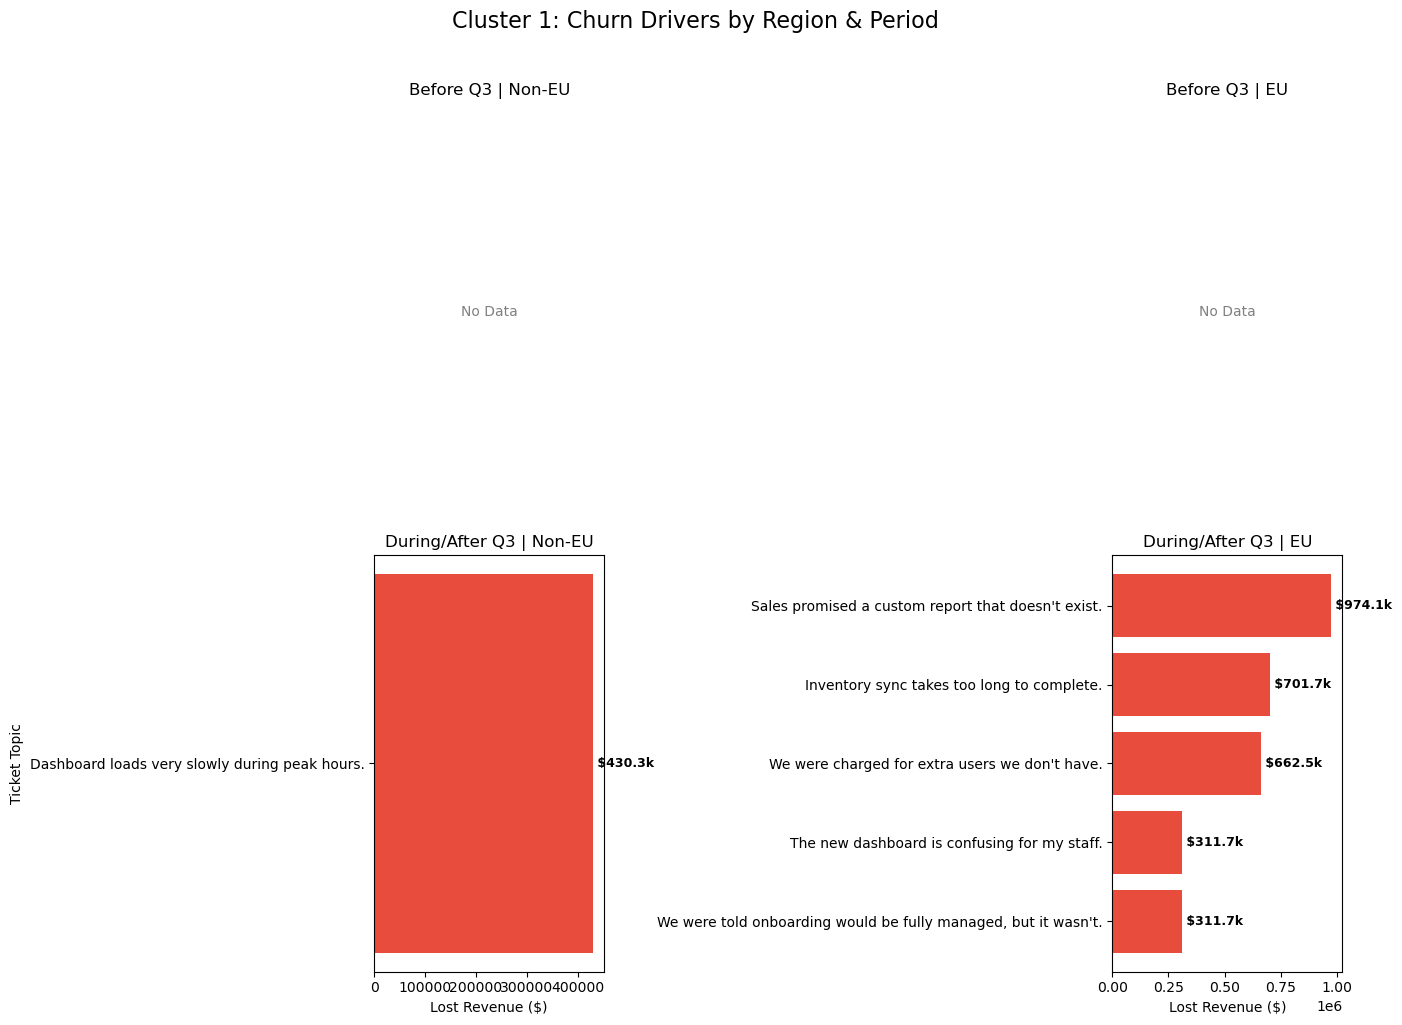

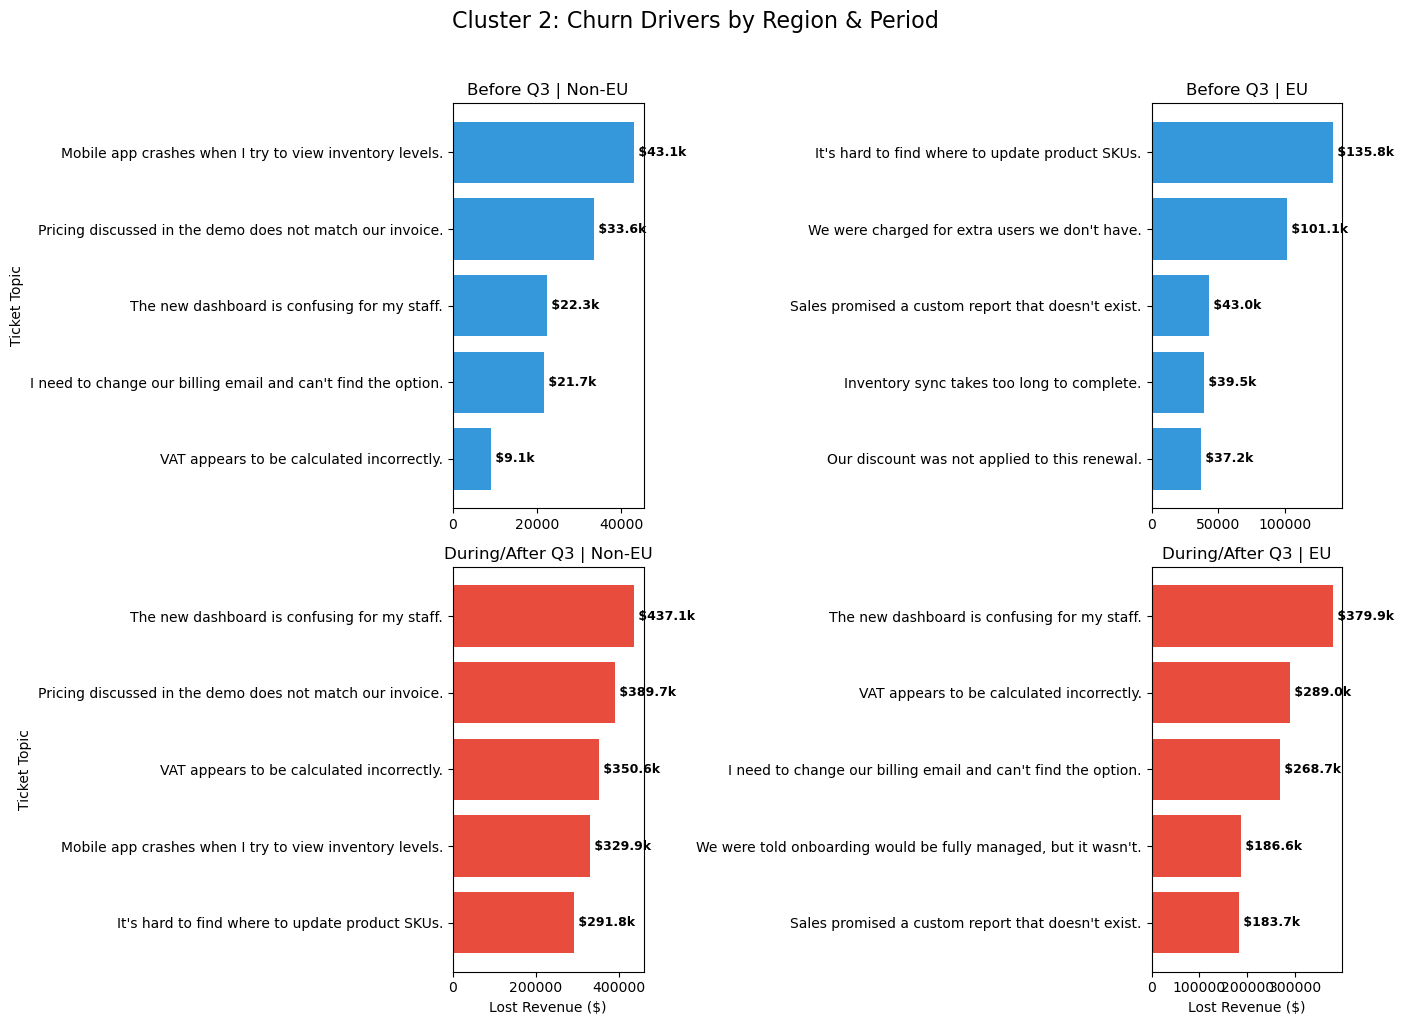

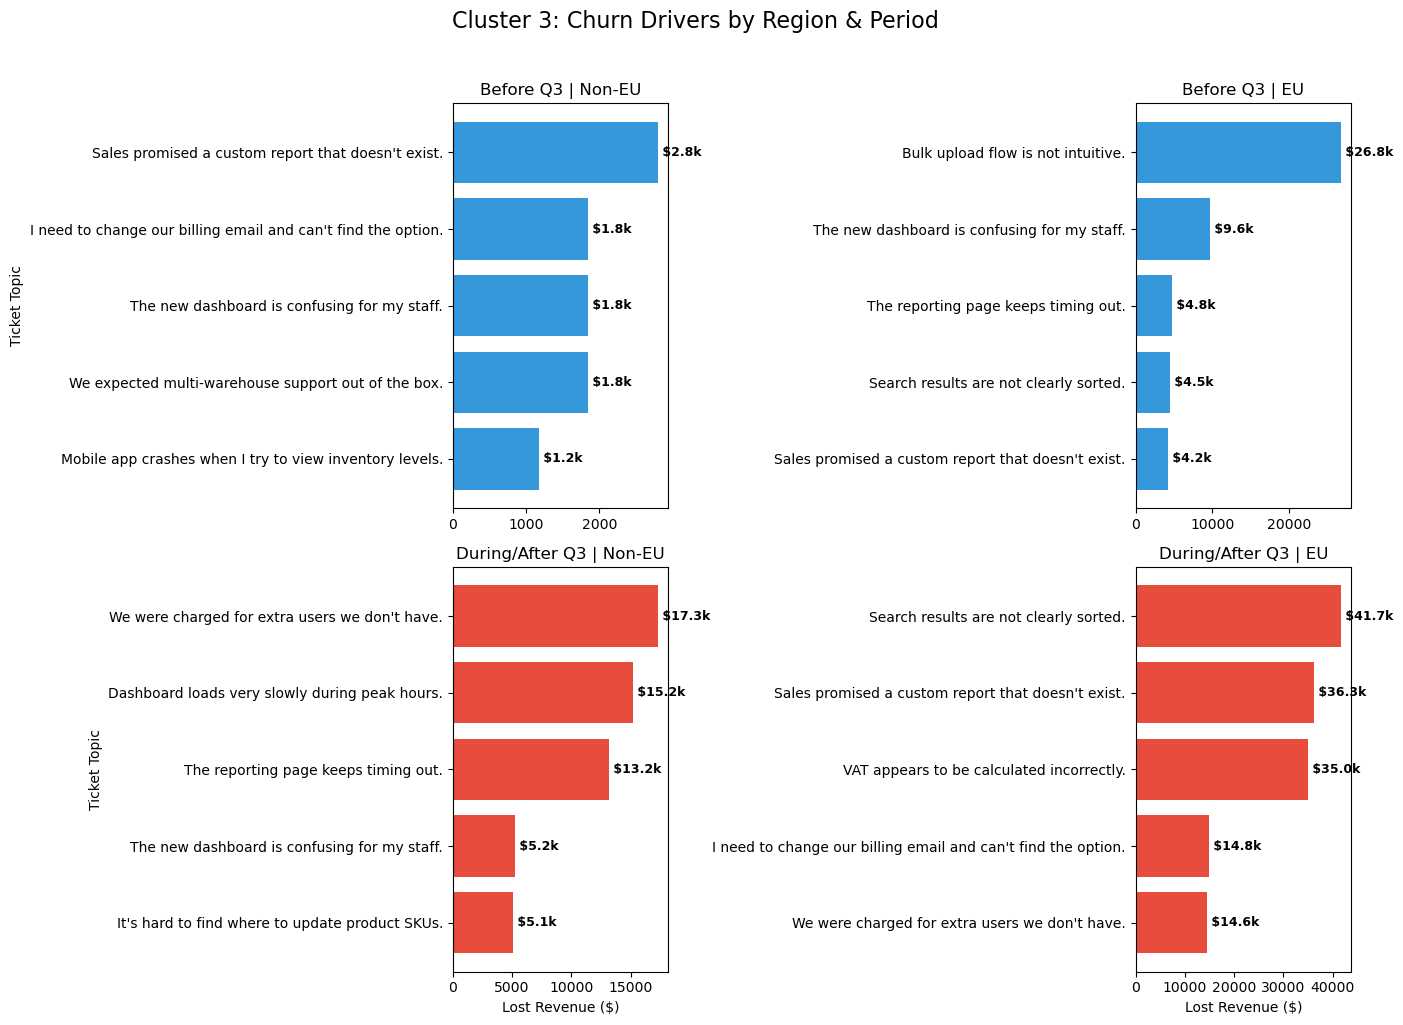

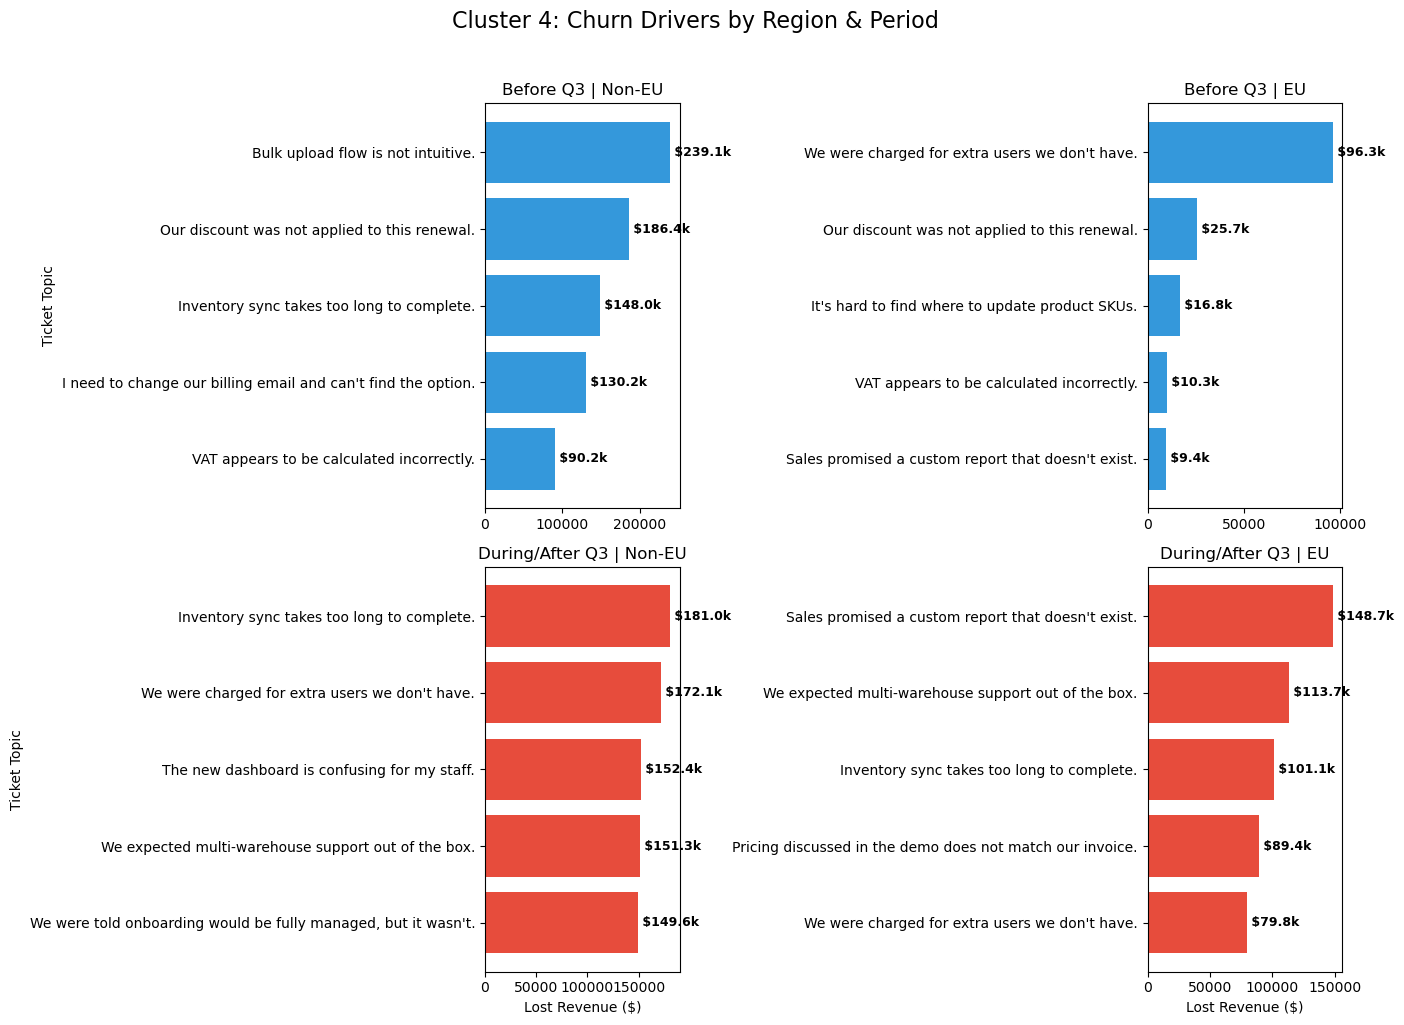

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ... [Keep your loading and merge code as is] ...

# 1) Pick priority clusters
priority_clusters = [2, 1, 4, 3]
df_priority = df_tickets[df_tickets["hier_cluster"].isin(priority_clusters)].copy()

# 2) Filter for CHURNED customers only
churned_only = df_priority[df_priority["is_churned"] == 1].copy()

# Ensure is_eu is standard (0/1 or False/True) -> Map to String for cleaner plots
# (Adjust logic if your column is already 'Yes'/'No')
churned_only['region_label'] = churned_only['is_eu'].apply(lambda x: "EU" if x == 1 else "Non-EU")

# 3) Group by Cluster, Region, Period, AND Ticket Text
# This now pivots data by 4 dimensions
churn_text_drivers = (
    churned_only
    .groupby(["hier_cluster", "region_label", "Q3_Status", "ticket_text"])["lost_revenue"]
    .sum()
    .reset_index(name="lost_revenue")
)

# 4) PLOTTING: Create a 2x2 Grid for each Cluster
topk = 5
periods = ['Before Q3', 'During/After Q3'] # Ensure these match your data values exactly
regions = ['Non-EU', 'EU']

for hc in sorted(churned_only["hier_cluster"].unique()):
    
    # Initialize 2x2 Figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Cluster {hc}: Churn Drivers by Region & Period", fontsize=16, y=1.02)
    
    # Loop through Rows (Time) and Cols (Region)
    for i, period in enumerate(periods):
        for j, region in enumerate(regions):
            
            ax = axes[i, j]
            
            # Filter for this specific quadrant
            sub = churn_text_drivers[
                (churn_text_drivers["hier_cluster"] == hc) & 
                (churn_text_drivers["Q3_Status"] == period) &
                (churn_text_drivers["region_label"] == region)
            ]
            
            # Sort by Revenue
            sub = sub.sort_values("lost_revenue", ascending=False).head(topk)
            
            # Handle empty data (e.g., if no EU customers churned in Q3)
            if sub.empty:
                ax.text(0.5, 0.5, "No Data", ha='center', va='center', color='gray')
                ax.set_title(f"{period} | {region}")
                ax.set_axis_off()
                continue

            # Color Logic: Red for the 'Crisis' period (During Q3)
            color = '#E74C3C' if 'During' in period else '#3498DB'
            
            # Plot
            ax.barh(sub["ticket_text"].astype(str), sub["lost_revenue"], color=color)
            ax.invert_yaxis() # Top driver at the top
            
            # Titles & Formatting
            ax.set_title(f"{period} | {region}")
            if j == 0: ax.set_ylabel("Ticket Topic") # Only on left plots
            if i == 1: ax.set_xlabel("Lost Revenue ($)") # Only on bottom plots
            
            # Add dollar labels
            for idx, v in enumerate(sub["lost_revenue"]):
                ax.text(v, idx, f" ${v/1000:.1f}k", ha='left', va='center', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

I attributed a churned customer’s lost revenue to the issue categories that customer raised